Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

Mobile Games AB Testing with Cookie Cats

https://docs.google.com/spreadsheets/d/1Dj6c6pmdg1N_rL3T2zg4HxnBo7poBgm6-g-40ATIJmE/edit#gid=1733885895

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm, t, kstest, shapiro
from statsmodels.stats.power import TTestIndPower

In [2]:
df = pd.read_excel('./результаты А_B.xlsx')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1


In [3]:
# Проведем первичное исследование данных. Посмотрим нет ли пропущенных значений.
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


,userid,sum_gamerounds,retention_1,retention_7
count,9.018900e+04,90189.000000,90189.000000,90189.000000
mean,4.998412e+06,51.872457,0.445210,0.186065
std,2.883286e+06,195.050858,0.496992,0.389161
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.512230e+06,5.000000,0.000000,0.000000
50%,4.995815e+06,16.000000,0.000000,0.000000
75%,7.496452e+06,51.000000,1.000000,0.000000
max,9.999861e+06,49854.000000,1.000000,1.000000


In [4]:
# Посмотрим количество уникальных значений.
df.nunique()

userid            90189
version               2
sum_gamerounds      942
retention_1           2
retention_7           2
dtype: int64

#### Предварительный анализ данных.
Предоставленные данные не имеют пропусков. Есть две группы пользователей gate_30 и gate_40. У нас нет дополнительных данных о сплитовании и параметрах логирования данныХ, потому за конрольную группу возьмем gate_30, а за тестовую gate_40. Ключевой измеряемой метрикой является gamerounds, добавочными удержание пользователей после первого и 7 дней.	 

In [5]:
# Изучим данные ключевой метрики на выбросы.

df.nlargest(10, ['sum_gamerounds'])

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,0,1
7912,871500,gate_30,2961,1,1
29417,3271615,gate_40,2640,1,0
43671,4832608,gate_30,2438,1,1
48188,5346171,gate_40,2294,1,1
46344,5133952,gate_30,2251,1,1
87007,9640085,gate_30,2156,1,1
36933,4090246,gate_40,2124,1,1
88328,9791599,gate_40,2063,1,1
6536,725080,gate_40,2015,1,1


In [6]:
# У нас есть один пользователй, который своей активностью превосходит всех остальных более чем в 100 раз. Уберем этот выброс из данных. 

df = df[df.sum_gamerounds < 3000]

In [7]:
# Определим размеры выборок и изучим группы отдельно

df.version.value_counts()

version
gate_40    45489
gate_30    44699
Name: count, dtype: int64

In [8]:
df[df['version']=='gate_30'].describe()

,userid,sum_gamerounds,retention_1,retention_7
count,4.469900e+04,44699.000000,44699.000000,44699.000000
mean,4.987532e+06,51.342111,0.448198,0.190183
std,2.881051e+06,102.057598,0.497315,0.392450
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.505463e+06,5.000000,0.000000,0.000000
50%,4.983630e+06,17.000000,0.000000,0.000000
75%,7.481522e+06,50.000000,1.000000,0.000000
max,9.999710e+06,2961.000000,1.000000,1.000000


In [9]:
df[df['version']=='gate_40'].describe()

,userid,sum_gamerounds,retention_1,retention_7
count,4.548900e+04,45489.000000,45489.000000,45489.000000
mean,5.009073e+06,51.298776,0.442283,0.182000
std,2.885496e+06,103.294416,0.496663,0.385849
min,3.770000e+02,0.000000,0.000000,0.000000
25%,2.517171e+06,5.000000,0.000000,0.000000
50%,5.007329e+06,16.000000,0.000000,0.000000
75%,7.510762e+06,52.000000,1.000000,0.000000
max,9.999861e+06,2640.000000,1.000000,1.000000


Группы распределены условно равномерно, никаких серьезных различий между ними не обнаружено.

Проверим распределение выборок на нормальность.

C:\Users\Лина\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\graphics\gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


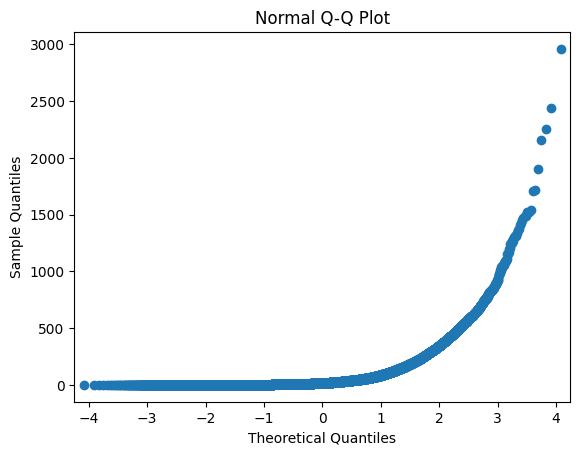

In [10]:
control = df['sum_gamerounds'][df['version'] == 'gate_30']
test = df['sum_gamerounds'][df['version'] == 'gate_40']

fig = sm.qqplot(control, color='green')
plt.title('Normal Q-Q Plot')
plt.show;

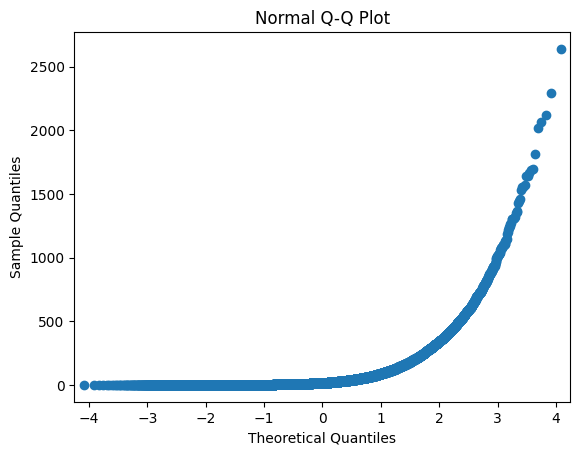

In [11]:
fig = sm.qqplot(test, color='green')
plt.title('Normal Q-Q Plot')
plt.show;

In [12]:
print(kstest(control, 'norm'))
print(kstest(test, 'norm'))
print(shapiro(control))
print(shapiro(test))

KstestResult(statistic=0.8724153079945488, pvalue=0.0, statistic_location=2, statistic_sign=-1)
KstestResult(statistic=0.8707186187388001, pvalue=0.0, statistic_location=2, statistic_sign=-1)
ShapiroResult(statistic=0.4886430501937866, pvalue=0.0)
ShapiroResult(statistic=0.48256635665893555, pvalue=0.0)


C:\Users\Лина\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Распределение не нормально. 

In [13]:
# Так как у нас нет нормального распределения для оценки статзначимости используем критерий Манна Уитни. 

stats.mannwhitneyu(x=control, y = test)

MannwhitneyuResult(statistic=1024285761.5, pvalue=0.05089155279145376)

In [14]:
# Р-value Манна Уитни близко к альфе 0.05. Проведен дополнительное сравнение используя двухвыборочный t-тест

stats.ttest_ind(control, test, equal_var = False)

Ttest_indResult(statistic=0.06337426312892294, pvalue=0.9494686215464458)

Между двумя выборками нет стат знначимых отличий в ключевой метрике sum_gamerounds. Выкатывать изменение нет смысла.
Изучим добавочные метрики 

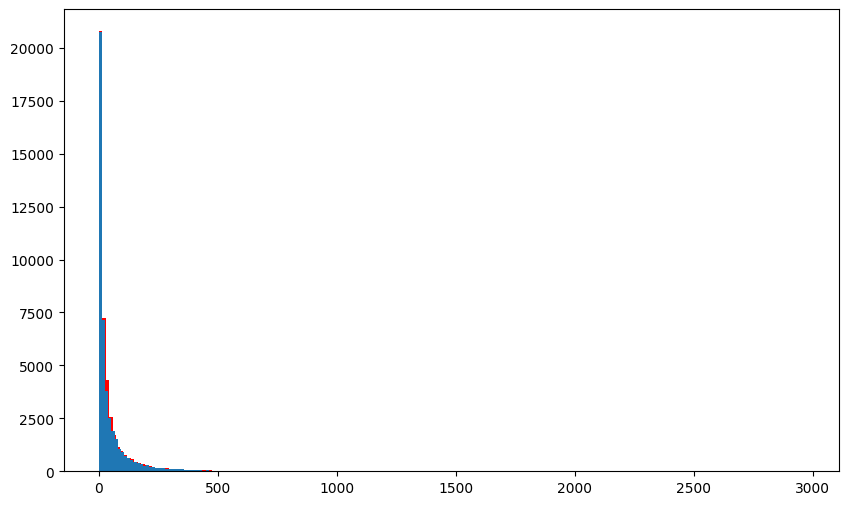

In [15]:
# Построим гистаграмму показывающую сколько раз играет каждый пользователь.

plt.figure(figsize=(10, 6))
plt.hist(control, color='r', bins=200)
plt.hist(test,  bins=200)
plt.show()

Text(0.5, 1.0, 'Распределение сыграннных раунов на игроков')

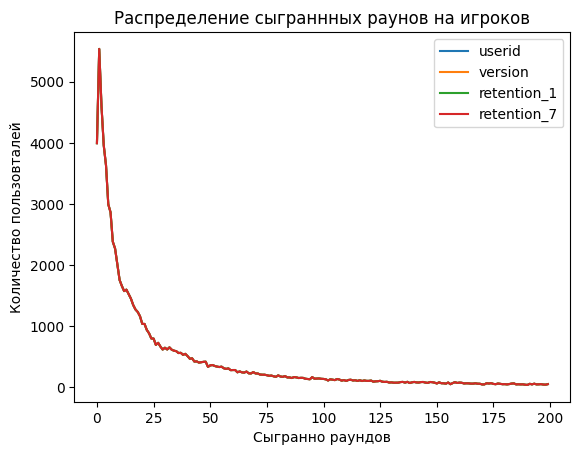

In [16]:
plot_df = df.groupby('sum_gamerounds').count()

ax = plot_df[:200].plot()
ax.set_xlabel('Сыгранно раундов')
ax.set_ylabel('Количество пользовталей')
ax.set_title('Распределение сыграннных раунов на игроков')

Основная масса пользователей играем менее 25 игр.

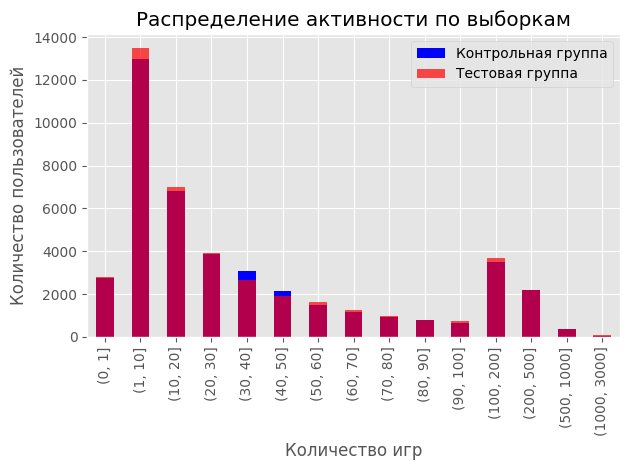

In [17]:
plt.style.use('ggplot')

control_group = df[df.version == 'gate_30']
test_group = df[df.version == 'gate_40']

bins = [0, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 500, 1000, 3000]
plot_GA = pd.DataFrame(control_group.groupby(pd.cut(control_group['sum_gamerounds'], bins=bins)).count())
plot_GB = pd.DataFrame(test_group.groupby(pd.cut(test_group['sum_gamerounds'],bins=bins)).count())

ax = plot_GA.plot(kind = 'bar', y='userid', color = 'blue', alpha = 1, title = 'Распределение активности по выборкам')
plot_GB.plot(kind = 'bar', y = 'userid', ax = ax, color = 'red', alpha = 0.7)
ax.set_xlabel('Количество игр')
ax.set_ylabel('Количество пользователей')
plt.legend(['Контрольная группа', 'Тестовая группа'])
plt.tight_layout()
plt.grid(True)

Между группами нет серьезной различий. Тестовые пользователи немнного активней до 10 игр, контрольная группа активней в дивпазоне 30-50 игр. Обращает всплеск активности пользователей в диапазоне 100-500 игр. Рекомедуется лучше изучить факторы влияюие на этих пользовталей. 

In [18]:
# Изучим метрику удержания пользовталей по выборкам.

df.groupby('version')['retention_1'].sum() / df.groupby('version')['retention_1'].count()


version
gate_30    0.448198
gate_40    0.442283
Name: retention_1, dtype: float64

In [19]:
df.groupby('version')['retention_7'].sum() / df.groupby('version')['retention_7'].count()

version
gate_30    0.190183
gate_40    0.182000
Name: retention_7, dtype: float64

Text(0, 0.5, 'Плотность/Удельный вес')

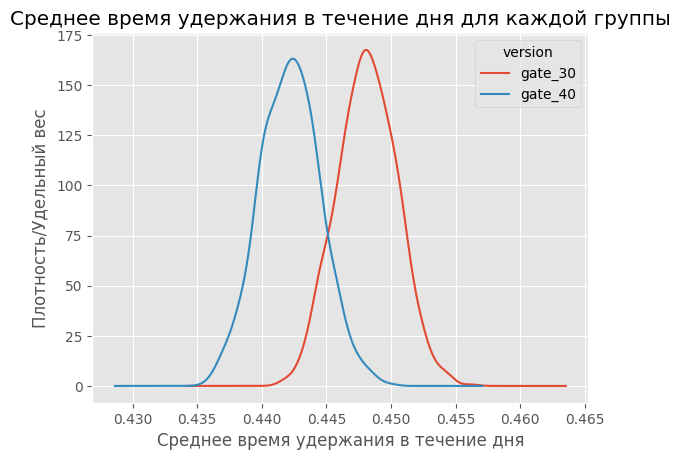

In [20]:
# Воспользуемся Bootstrapp для более детального иследования.

retention_1 = []
for i in range(1000):
  boot_mean = df.retention_1.sample(frac=1, replace=True).groupby(df.version).mean()
  retention_1.append(boot_mean)

boot_d = pd.DataFrame(retention_1)

ax = boot_d.plot.kde()
ax.set_title('Среднее время удержания в течение дня для каждой группы')
ax.set_xlabel('Среднее время удержания в течение дня')
ax.set_ylabel('Плотность/Удельный вес')

Text(0, 0.5, 'Плотность/Удельный вес')

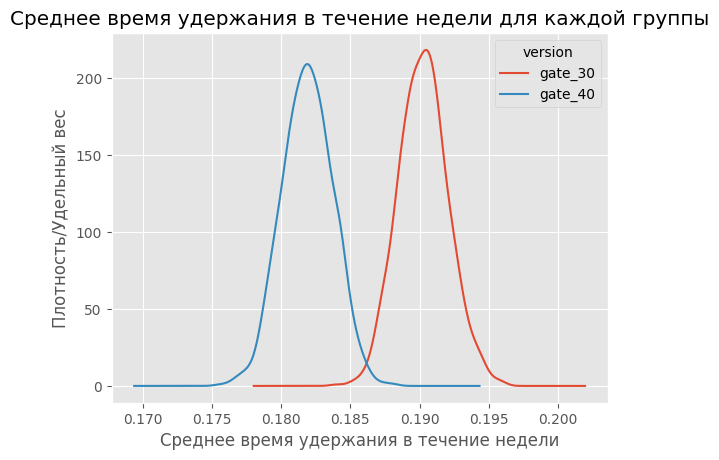

In [21]:
retention_7 = []
for i in range(1000):
  boot_mean = df.retention_7.sample(frac=1, replace=True).groupby(df.version).mean()
  retention_7.append(boot_mean)

boot_week = pd.DataFrame(retention_7)

ax = boot_week.plot.kde()
ax.set_title('Среднее время удержания в течение недели для каждой группы')
ax.set_xlabel('Среднее время удержания в течение недели')
ax.set_ylabel('Плотность/Удельный вес')

#### Вывод.
Наши иследования показали, что стат значимых различий по основнной метрики в выборках нет. По метрикам удержания пользовталей отличия минимальны и более высокие показатели у контрольной группы. Рекомендуется не внедрять изменения в продукт. ак же соит лучше изучиь какие факторы вляют на интерес у группы пользовтаелей сыгравших более 100 и менее 500 игр.